# Random Forest Prediction

In [73]:
# import packages
import pandas as pd
import os
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor

In [8]:
# Load data
trade_nodelist = pd.read_csv('../Output_datasets/Yearly_trade_data_prediction/trade_nodelist.csv')
trade_edgelist = pd.read_csv('../Output_datasets/Yearly_trade_data_prediction/trade_edgelist.csv')

In [14]:
trade_nodelist.columns

Index(['Unnamed: 0', 'year', 'gdp', 'total_population',
       'urban_population(%_of_total)', 'iso2', 'cnum', 'country', 'pays',
       'area', 'dis_int', 'landlocked', 'continent', 'citynum', 'langoff_1',
       'langoff_2', 'langoff_3', 'lang20_1', 'lang20_2', 'lang20_3',
       'lang20_4', 'lang9_1', 'lang9_2', 'lang9_3', 'lang9_4', 'colonizer1',
       'colonizer2', 'colonizer3', 'colonizer4', 'short_colonizer1',
       'short_colonizer2', 'short_colonizer3', 'iso_numeric'],
      dtype='object')

In [20]:
trade_edgelist.columns

Index(['Unnamed: 0', 'Period', 'Value', 'iso_o', 'iso_d', 'contig',
       'comlang_off', 'comlang_ethno', 'colony', 'comcol', 'curcol', 'col45',
       'smctry', 'dist', 'distcap', 'distw', 'distwces'],
      dtype='object')

In [16]:
# merge datasets
trade_nodelist
#trade_nodelist.rename(columns = {'test':'TEST'}, inplace = True)

,Unnamed: 0,year,gdp,total_population,urban_population(%_of_total),iso2,cnum,country,pays,area,...,lang9_3,lang9_4,colonizer1,colonizer2,colonizer3,colonizer4,short_colonizer1,short_colonizer2,short_colonizer3,iso_numeric
0,0,1995,3.483894e+11,34946110.0,88.164,AR,32,Argentina,Argentine,2766889,...,NaN,NaN,ESP,NaN,NaN,NaN,NaN,NaN,NaN,32
1,1,1996,3.676438e+11,35389362.0,88.366,AR,32,Argentina,Argentine,2766889,...,NaN,NaN,ESP,NaN,NaN,NaN,NaN,NaN,NaN,32
2,2,1997,3.974635e+11,35815971.0,88.564,AR,32,Argentina,Argentine,2766889,...,NaN,NaN,ESP,NaN,NaN,NaN,NaN,NaN,NaN,32
3,3,1998,4.127666e+11,36233195.0,88.759,AR,32,Argentina,Argentine,2766889,...,NaN,NaN,ESP,NaN,NaN,NaN,NaN,NaN,NaN,32
4,4,1999,3.987925e+11,36653031.0,88.952,AR,32,Argentina,Argentine,2766889,...,NaN,NaN,ESP,NaN,NaN,NaN,NaN,NaN,NaN,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2145,2145,2015,2.125122e+10,16248230.0,41.907,ZM,894,Zambia,Zambie,752614,...,NaN,NaN,GBR,NaN,NaN,NaN,NaN,NaN,NaN,894
2146,2146,2016,2.205381e+10,16767761.0,42.438,ZM,894,Zambia,Zambie,752614,...,NaN,NaN,GBR,NaN,NaN,NaN,NaN,NaN,NaN,894
2147,2147,2017,2.282665e+10,17298054.0,42.976,ZM,894,Zambia,Zambie,752614,...,NaN,NaN,GBR,NaN,NaN,NaN,NaN,NaN,NaN,894
2148,2148,2018,2.374759e+10,17835893.0,43.521,ZM,894,Zambia,Zambie,752614,...,NaN,NaN,GBR,NaN,NaN,NaN,NaN,NaN,NaN,894


In [42]:
trade=pd.merge(trade_edgelist,trade_nodelist,how='left', left_on=['iso_o','Period'], right_on=['cnum','year'],suffixes=('', '_o'))
trade=pd.merge(trade,trade_nodelist,how='left', left_on=['iso_d','Period'], right_on=['cnum','year'],suffixes=('', '_d'))
trade

,Unnamed: 0,Period,Value,iso_o,iso_d,contig,comlang_off,comlang_ethno,colony,comcol,...,lang9_3_d,lang9_4_d,colonizer1_d,colonizer2_d,colonizer3_d,colonizer4_d,short_colonizer1_d,short_colonizer2_d,short_colonizer3_d,iso_numeric_d
0,0,1995,0,32,32,0,0,0,0,0,...,NaN,NaN,ESP,NaN,NaN,NaN,NaN,NaN,NaN,32.0
1,1,1996,0,32,32,0,0,0,0,0,...,NaN,NaN,ESP,NaN,NaN,NaN,NaN,NaN,NaN,32.0
2,2,1997,0,32,32,0,0,0,0,0,...,NaN,NaN,ESP,NaN,NaN,NaN,NaN,NaN,NaN,32.0
3,3,1998,0,32,32,0,0,0,0,0,...,NaN,NaN,ESP,NaN,NaN,NaN,NaN,NaN,NaN,32.0
4,4,1999,0,32,32,0,0,0,0,0,...,NaN,NaN,ESP,NaN,NaN,NaN,NaN,NaN,NaN,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184895,184895,2015,0,894,894,0,0,0,0,0,...,NaN,NaN,GBR,NaN,NaN,NaN,NaN,NaN,NaN,894.0
184896,184896,2016,0,894,894,0,0,0,0,0,...,NaN,NaN,GBR,NaN,NaN,NaN,NaN,NaN,NaN,894.0
184897,184897,2017,0,894,894,0,0,0,0,0,...,NaN,NaN,GBR,NaN,NaN,NaN,NaN,NaN,NaN,894.0
184898,184898,2018,0,894,894,0,0,0,0,0,...,NaN,NaN,GBR,NaN,NaN,NaN,NaN,NaN,NaN,894.0


<AxesSubplot:>

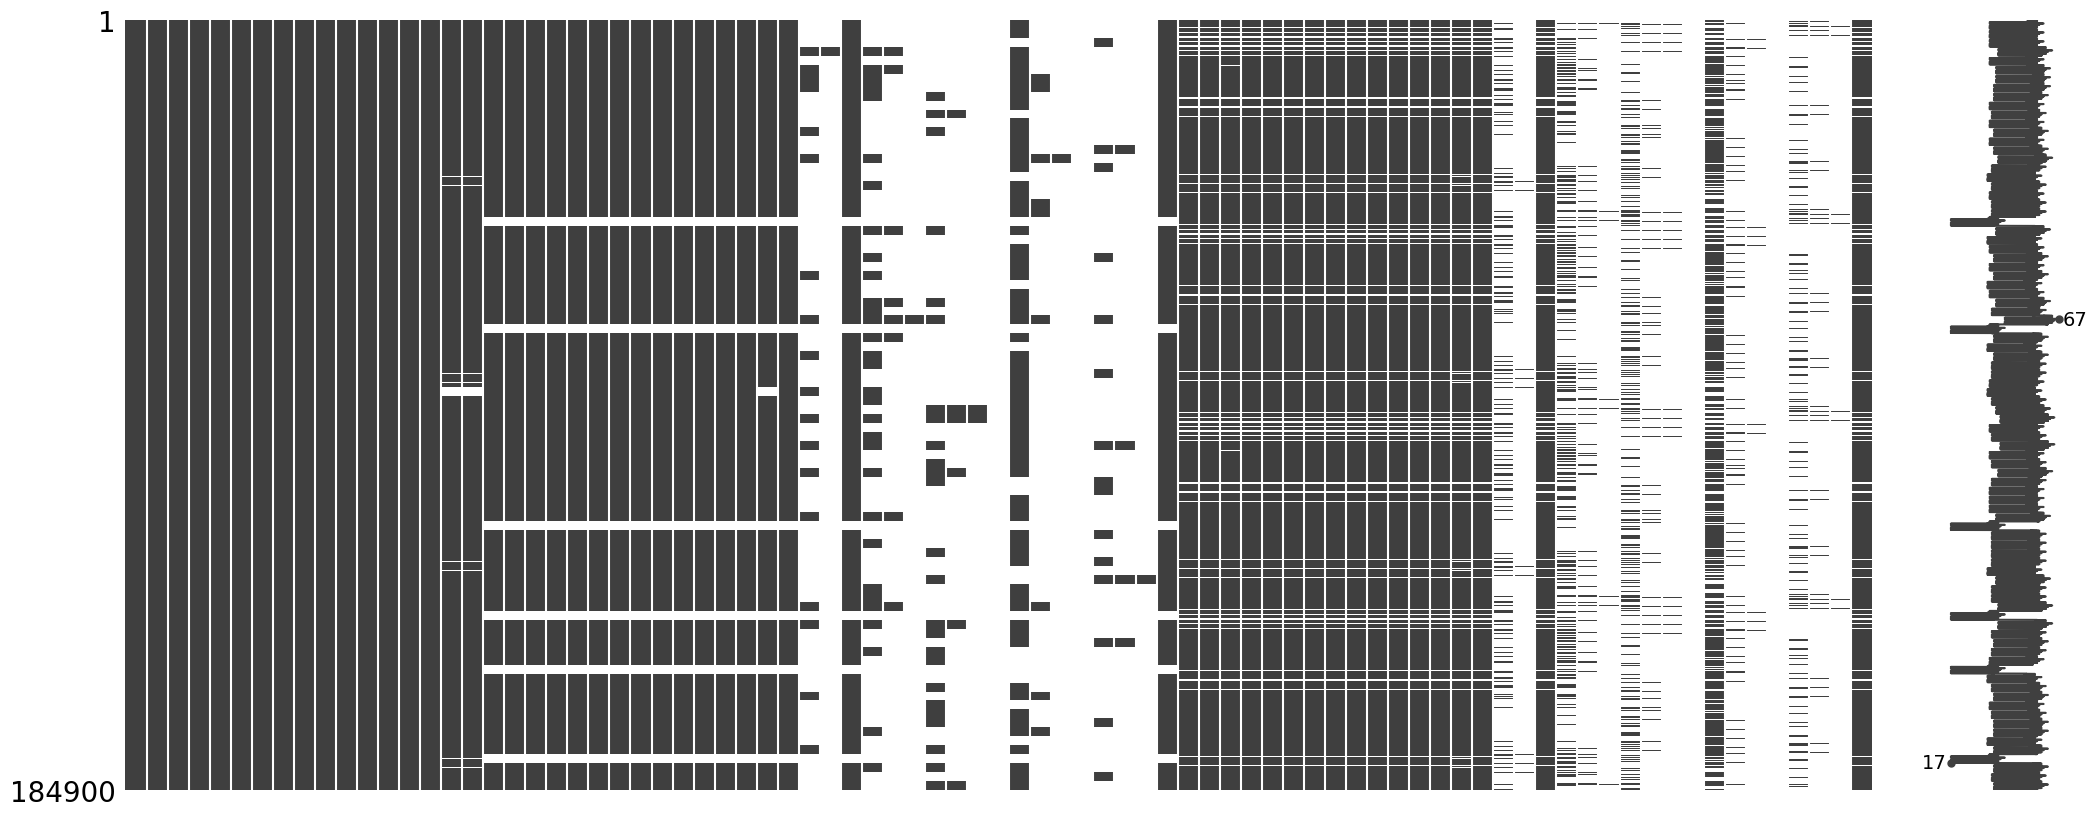

In [46]:
import missingno as msno

msno.matrix(trade)

<AxesSubplot:>

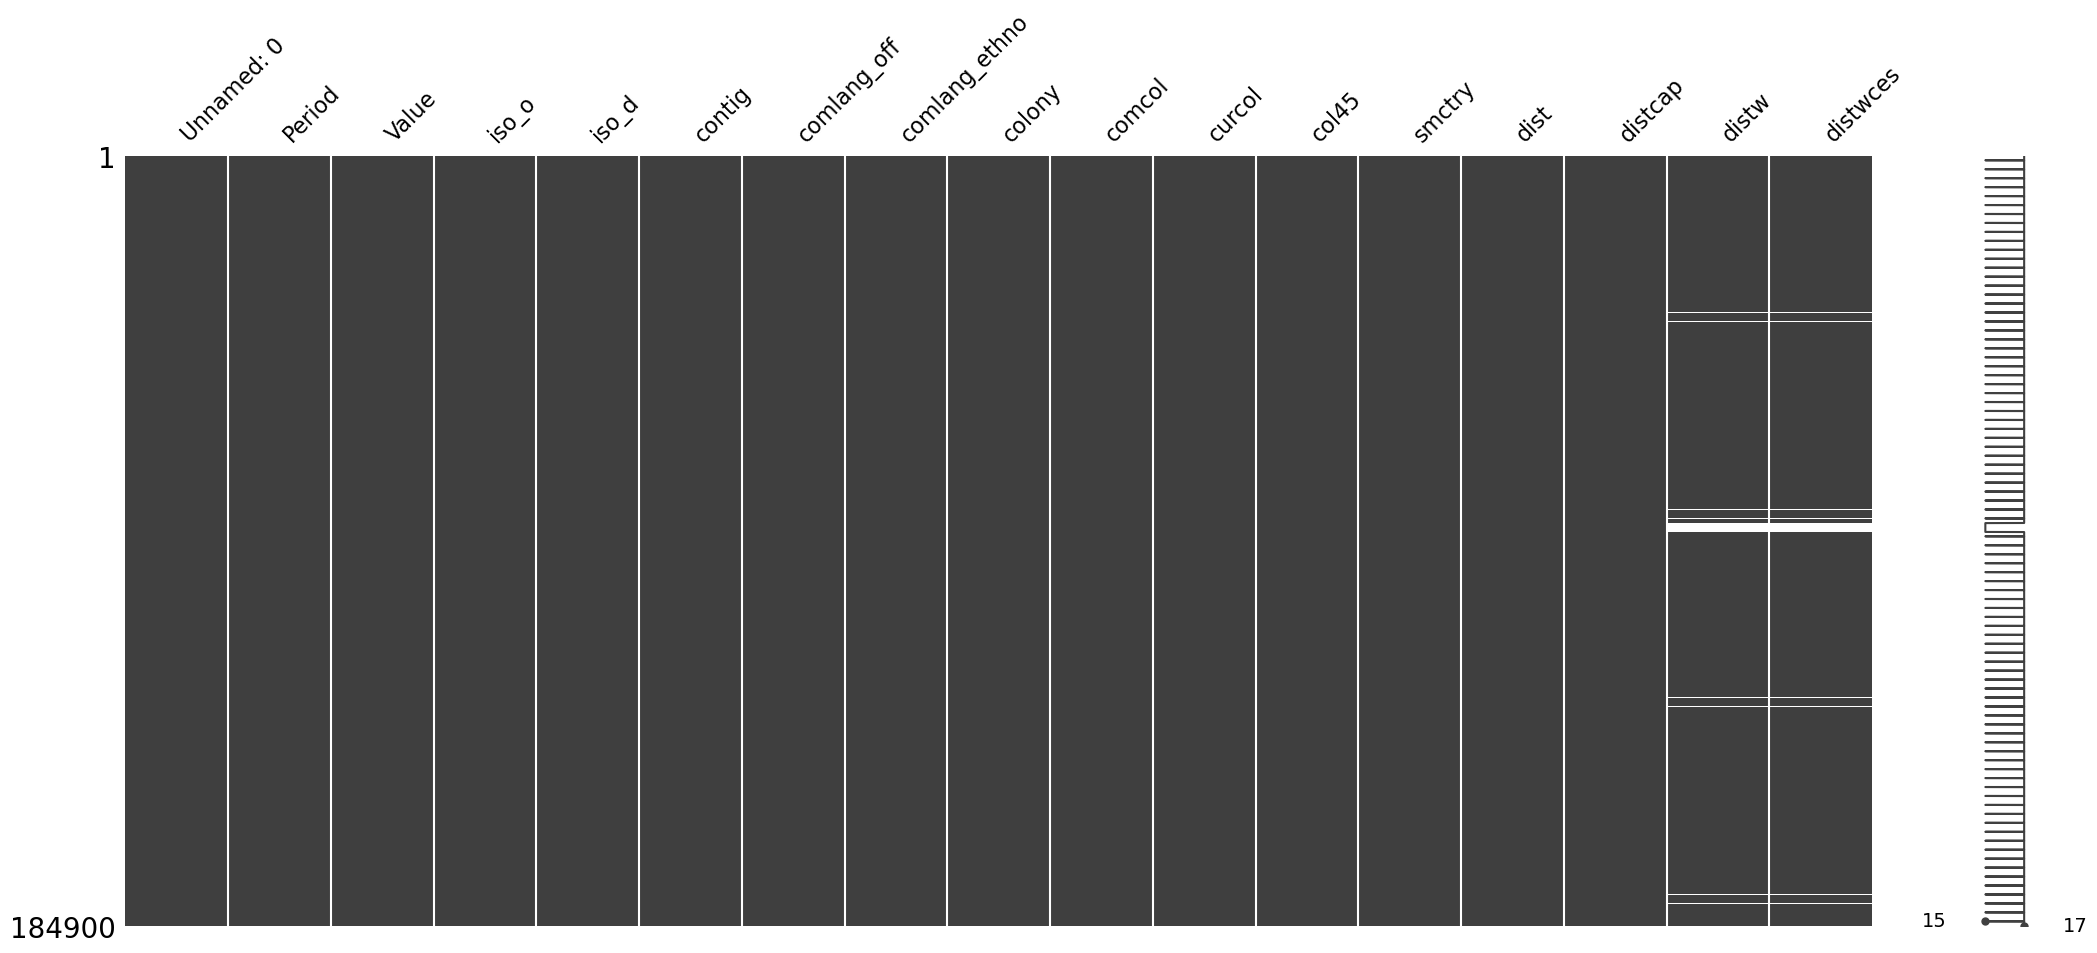

In [47]:
import missingno as msno

msno.matrix(trade_edgelist)

In [50]:
trade_edgelist.drop(['distw', 'distwces'], axis=1)

,Unnamed: 0,Period,Value,iso_o,iso_d,contig,comlang_off,comlang_ethno,colony,comcol,curcol,col45,smctry,dist,distcap
0,0,1995,0,32,32,0,0,0,0,0,0,0,0,625.64746,625.64746
1,1,1996,0,32,32,0,0,0,0,0,0,0,0,625.64746,625.64746
2,2,1997,0,32,32,0,0,0,0,0,0,0,0,625.64746,625.64746
3,3,1998,0,32,32,0,0,0,0,0,0,0,0,625.64746,625.64746
4,4,1999,0,32,32,0,0,0,0,0,0,0,0,625.64746,625.64746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184895,184895,2015,0,894,894,0,0,0,0,0,0,0,0,326.30215,326.30215
184896,184896,2016,0,894,894,0,0,0,0,0,0,0,0,326.30215,326.30215
184897,184897,2017,0,894,894,0,0,0,0,0,0,0,0,326.30215,326.30215
184898,184898,2018,0,894,894,0,0,0,0,0,0,0,0,326.30215,326.30215


In [69]:
data = trade_edgelist[["Period", "Value", "iso_o", "iso_d", "contig", "comlang_off", "comlang_ethno", "colony", "comcol", "curcol", "col45", "smctry", "dist", "distcap"]]
data_train = data[(data["Period"] >= 1995) & (data["Period"] <= 1999)]
data_test = data[(data["Period"] == 2000)]
X_train= data_train.drop(['Value'], axis=1)
X_test= data_test.drop(['Value'], axis=1)
y_train = data_train['Value']
y_test = data_test['Value']

In [92]:
regr = RandomForestRegressor(max_depth=5, random_state=42)

trade_out = pd.DataFrame()
for year in range(1995, 2015):
    print(year)
    data_train = data[(data["Period"] >= year) & (data["Period"] <= year + 4)]
    data_test = data[(data["Period"] == year + 5)]
    X_train= data_train.drop(['Value'], axis=1)
    X_test= data_test.drop(['Value'], axis=1)
    y_train = data_train['Value']
    y_test = data_test['Value']

    regr.fit(X_train, y_train)
    y_predic = regr.predict(X_test)

    X_test['Value'] = y_test
    X_test ['Prediction'] = y_predic
    #trade_out = trade_out.append(X_test)
    trade_out = pd.concat([trade_out, X_test])
    

1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014


In [94]:
trade_out

,Period,iso_o,iso_d,contig,comlang_off,comlang_ethno,colony,comcol,curcol,col45,smctry,dist,distcap,Value,Prediction
5,2000,32,32,0,0,0,0,0,0,0,0,625.64746,625.64746,0,7.856713e+08
30,2000,32,36,0,0,0,0,0,0,0,0,11801.36400,11733.88000,71213431,2.410584e+08
55,2000,32,40,0,0,0,0,0,0,0,0,11833.75900,11833.75900,81149089,2.410584e+08
80,2000,32,68,1,1,1,0,0,0,0,1,2239.66940,1858.05360,20033861,3.167539e+09
105,2000,32,76,1,0,0,0,0,0,0,0,1691.06700,2353.25700,6478453841,3.687254e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184799,2019,894,834,1,1,0,0,1,0,0,0,1538.83680,1317.74270,204517386,6.744888e+09
184824,2019,894,840,0,1,1,0,0,0,0,0,12156.13200,12399.13200,186460168,1.546488e+08
184849,2019,894,854,0,0,0,0,0,0,0,0,4521.54830,4521.54830,3978,4.602391e+07
184874,2019,894,858,0,0,0,0,0,0,0,0,8541.53800,8541.53800,508299,4.602391e+07
